# 基于btc市场的高频交易探索
## - EDA

In [22]:
# import lib
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
import matplotlib.pyplot as plt

In [50]:
filename = '../../../data/btc_20170721.csv.gz'
data = pd.read_csv(filename, parse_dates=['time'], index_col='time')
data['time'] = data.index

In [9]:
print(f"Loaded {data.shape[0]:,} trades")
print(f"Loaded {data.order_id.nunique():,} orders")

Loaded 2,169,450 trades
Loaded 723,880 orders


In [10]:
# filter keys
keys = ['price','remaining_size','side','reason','type','order_id']
data[keys].head()

,price,remaining_size,side,reason,type,order_id
time,,,,,,
2017-07-21 08:52:06.163,2715.35,NaN,buy,NaN,received,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4
2017-07-21 08:52:06.163,2715.35,0.089439,buy,NaN,open,6fdae78f-f00f-4dee-95f2-0ffb6ca2dfb4
2017-07-21 08:52:06.165,2708.71,0.200000,buy,canceled,done,a7d073fb-c741-4f87-8a43-699462e597a4
2017-07-21 08:52:06.167,2708.66,0.500000,buy,canceled,done,5936f368-9b87-477e-9adc-83f14a525491
2017-07-21 08:52:06.168,2708.71,0.200000,buy,canceled,done,71dbb9bf-8a6c-4c0b-8ca2-259d16be43e1


#### 将数据进行清洗后，可发现数据现在保留了以下几个字段：
- `price`：价格
- `amount`：数量
- `side`：交易方向
- `status`：交易状态
- `unique order id`：订单id
- 观察前五个订单可发现，里面有三个订单是取消订单，后续的数据中还有很多

#### 数据频率

In [16]:
dt = data.time.diff().iloc[1:].dt
dt = dt.seconds.astype(np.float) + dt.microseconds*1e-6
dt *= 1e3 # convert to milliseconds
dt.describe()

/tmp/ipykernel_423/2232415720.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dt = dt.seconds.astype(np.float) + dt.microseconds*1e-6


count    2.169449e+06
mean     7.917533e+00
std      1.886929e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      9.000000e+00
max      1.099000e+03
Name: time, dtype: float64

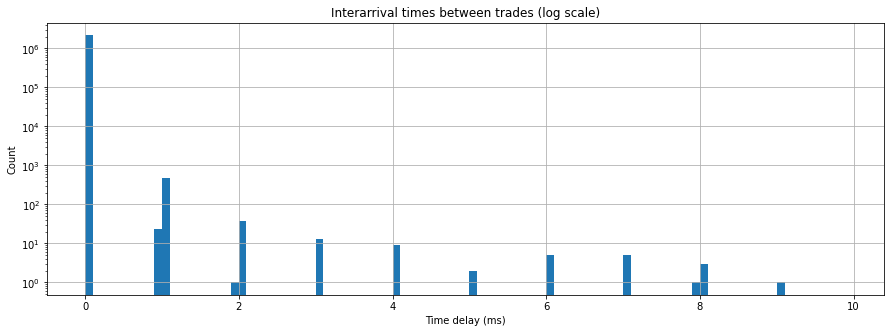

In [20]:
dt.sort_values().diff().hist(bins=np.arange(0, 10, 0.1))
plt.yscale('log')
plt.xlabel('Time delay (ms)')
plt.ylabel('Count')
plt.title('Interarrival times between trades (log scale)')
plt.show()

In [21]:
print(f"最小非零时间间隔: {dt[dt>0].min():.2f} ms")

最小非零时间间隔: 1.00 ms


#### 大量的订单同时发生，最小的*非零*的时间延迟值是1**ms**。
#### 每个订单_id最多出现三次（99.01%），这意味着，订单到达，订单等待（"开放"），订单被匹配或取消。

In [24]:
for order, freq in Counter(data.groupby('order_id').size()).most_common():
    print(f"订单次数: {order:3d}  频率: {freq:6d}")

订单次数:   3  频率: 716746
订单次数:   2  频率:   5048
订单次数:   1  频率:   2086


#### 从订单交易结果上的分析

In [28]:
data.groupby('reason').size()
print(f"订单取消次数: {data.reason.str.contains('canceled').sum():,}, 占比: {data.reason.str.contains('canceled').mean():.2%}")
print(f"订单完成次数: {data.reason.str.contains('filled').sum():,}, 占比: {data.reason.str.contains('filled').mean():.2%}")

订单取消次数: 714,648, 占比: 99.02%
订单完成次数: 7,053, 占比: 0.98%


#### 从组合订单交易报单上的分析

In [29]:
group = data[(data.price==2707.81) & (data.remaining_size==0.5)]
group[['price','remaining_size','side','reason','type','order_id']].tail()

,price,remaining_size,side,reason,type,order_id
time,,,,,,
2017-07-21 08:58:07.488,2707.81,0.5,buy,canceled,done,04211005-4140-44c5-98d6-65fcec8eb9e5
2017-07-21 08:58:57.500,2707.81,0.5,buy,NaN,open,17eb23e8-b967-4413-89ed-31ab57f2fc3c
2017-07-21 08:58:57.741,2707.81,0.5,buy,canceled,done,17eb23e8-b967-4413-89ed-31ab57f2fc3c
2017-07-21 10:47:39.363,2707.81,0.5,buy,NaN,open,44c11417-a3a0-4d3c-9672-5b35d59e97e4
2017-07-21 10:47:39.882,2707.81,0.5,buy,canceled,done,44c11417-a3a0-4d3c-9672-5b35d59e97e4


#### 锁定订单号为`04211005-4140-44c5-98d6-65fcec8eb9e5`的交易报单

In [30]:
data[data.order_id=="04211005-4140-44c5-98d6-65fcec8eb9e5"][['price','remaining_size','side','reason','order_id','type', 'bid','ask']]

,price,remaining_size,side,reason,order_id,type,bid,ask
time,,,,,,,,
2017-07-21 08:58:07.193,2707.81,NaN,buy,NaN,04211005-4140-44c5-98d6-65fcec8eb9e5,received,2713.2,2714.51
2017-07-21 08:58:07.193,2707.81,0.5,buy,NaN,04211005-4140-44c5-98d6-65fcec8eb9e5,open,2713.2,2714.51
2017-07-21 08:58:07.488,2707.81,0.5,buy,canceled,04211005-4140-44c5-98d6-65fcec8eb9e5,done,2713.2,2714.51


#### 这个 "买入 "订单在2707.81美元的水平（当时的最佳ASK价格是2714.51）被放置**，并在295毫秒后被取消。似乎很明显，这个订单没有被执行的预期。让我们看看订单是否以高于或低于*295*毫秒的频率闪现。

/tmp/ipykernel_423/4013488072.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  duration = dt.dt.seconds.astype(np.float) + dt.dt.microseconds*1e-6


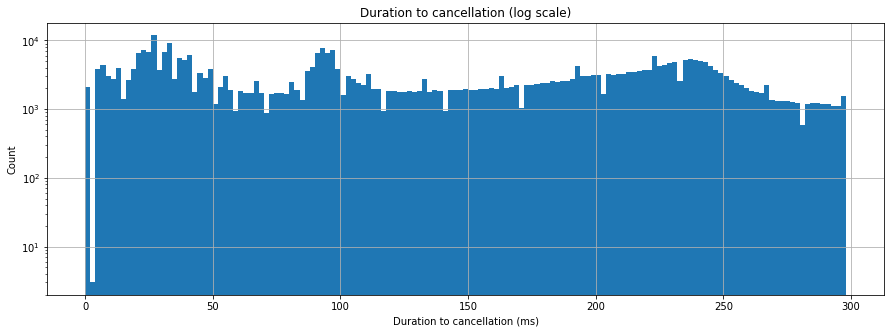

In [32]:
canceled_idx = data.order_id[data.reason=='canceled']
d = data[data.order_id.isin(canceled_idx)]
g = d.groupby('order_id')
dt = g.time.last() - g.time.first()
duration = dt.dt.seconds.astype(np.float) + dt.dt.microseconds*1e-6  
duration *= 1000
duration.hist(bins = np.arange(0 , 300, 2));
plt.yscale('log')
plt.xlabel('Duration to cancellation (ms)')
plt.ylabel('Count')
plt.title('Duration to cancellation (log scale)')
plt.show()

#### 在小于5毫秒的部分，有着很多闪烁订单

In [35]:
duration[duration>1].sort_values().head()

order_id
7f043088-f9ad-46f6-bfae-e577db3f7363    3.0
7162ca12-94eb-4b50-9249-3562152add62    3.0
42af6ed7-aeb1-4cb7-b787-e19c4a54f418    3.0
bf51ca32-5b6d-4a7d-ac78-433a1dd1f27e    4.0
47a435dc-3627-4d07-b702-cb27e60ec329    4.0
Name: time, dtype: float64

#### 锁定订单号为`7f043088-f9ad-46f6-bfae-e577db3f7363`的交易报单

In [36]:
data[data.order_id=="7f043088-f9ad-46f6-bfae-e577db3f7363"][keys+['bid','ask']]

,price,remaining_size,side,reason,type,order_id,bid,ask
time,,,,,,,,
2017-07-21 12:45:45.516,2769.99,NaN,sell,NaN,received,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96
2017-07-21 12:45:45.516,2769.99,0.5,sell,NaN,open,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96
2017-07-21 12:45:45.519,2769.99,0.5,sell,canceled,done,7f043088-f9ad-46f6-bfae-e577db3f7363,2767.87,2767.96


#### The FIX API throttles each command type (eg.: NewOrderSingle, OrderCancelRequest) to **30 commands per second**.

貌似超过API限制（最高的是每秒钟30条命令，意味着每33毫秒有一条命令）。

接下来，将检测哪些订单来自自动化机器人

In [47]:
def plotCancelBehaviourForPriceAndSize(price, size, lim=-1):
    q = data[((data.size==size) | (data.remaining_size==size)) & (data.price==price)].head(lim)
    t = q.time.diff().median()
    med_tick_s = t.seconds + t.microseconds*1e-6

    order_type = q.side.iloc[0]
    d = data.loc[q.index[0]:q.index[-1]]
    
    d.bid.plot(label="bid price"  )
    d.ask.plot(label="ask price")
    q[q.reason!="canceled"].price.plot(label="%s %.2f BTC @ %.2f" % (order_type, size, price), style='o')
    ylim0 = min(d.bid.min(), q.price.min())
    ylim1 = max(d.ask.max(), q.price.max())
    plt.vlines(q.index[q.reason=="canceled"], ylim0, ylim1, alpha = 0.2)
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.title("Cancelled orders along time for %.2f BTC @ $%.2f. Median tick: %.1f milliseconds" % (size, price,med_tick_s*1000))
    plt.legend(loc='best', frameon=True)
    
    plt.ylim(d.bid.min(), d.ask.max())
    plt.show()

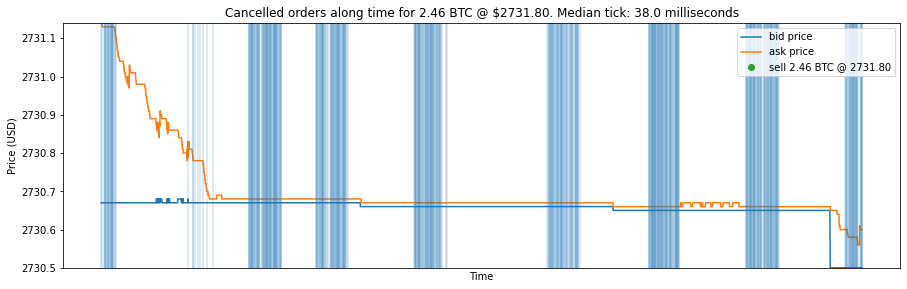

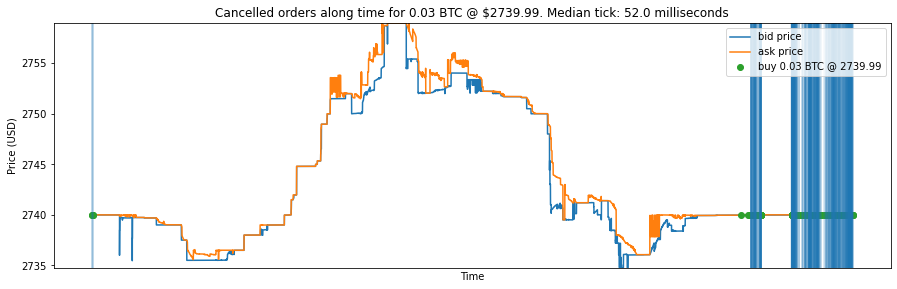

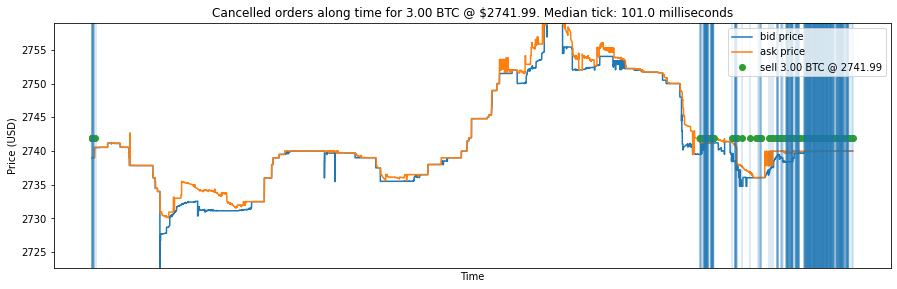

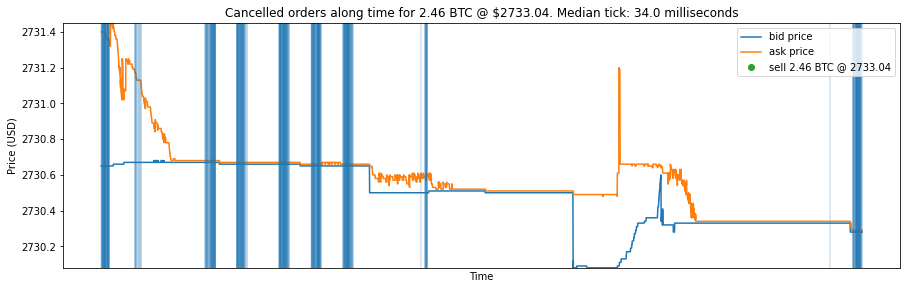

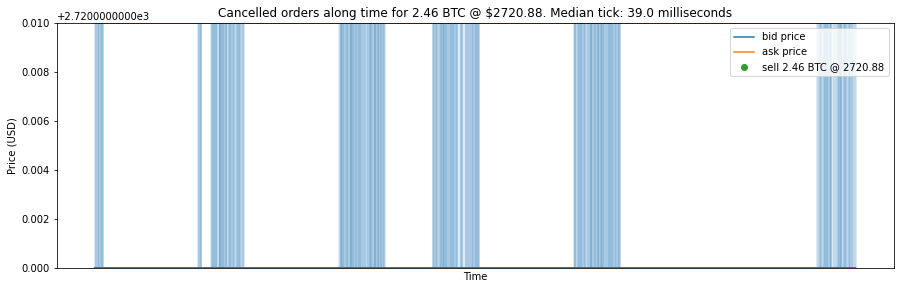

In [52]:
g = data.groupby(['price','size'])
for (price, size), i  in g.size().sort_values(ascending=False).head(5).items():
    plotCancelBehaviourForPriceAndSize(price, size, lim=1000)

### 检测

有证据表明，在2017年7月21日09:45:52和09:45:56之间存在高频欺骗行为。让我们看一下订单簿。红点是卖出订单（3 BTC @ $2741.99），垂直蓝线是取消订单，蓝线和黄线分别是买入和卖出价格。

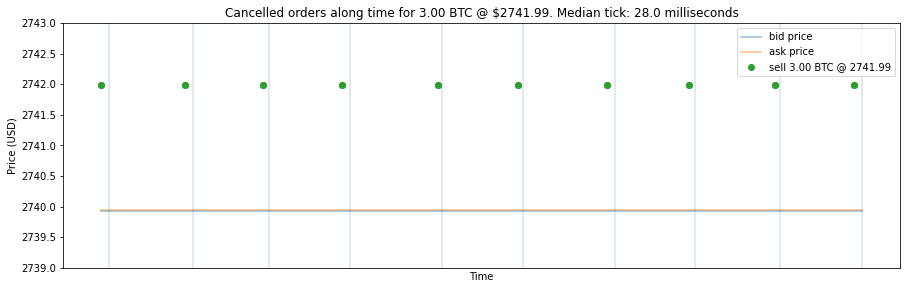

In [53]:
size = 3.00
price = 2741.99

q = data[((data['size']==size) | (data['remaining_size']==size)) & (data['price']==price)].head(1000)
q = q.loc['2017-7-21 9:45:52.000': '2017-7-21 9:45:56.000']
t = q.time.diff().median()
med_tick_s = t.seconds + t.microseconds*1e-6
order_type = q.side.iloc[0]
d = data.loc[q.index[0]:q.index[-1]]
d.bid.plot(label="bid price", alpha=0.5)
d.ask.plot(label="ask price", alpha=0.5)
q[q.reason!="canceled"].price.plot(label="%s %.2f BTC @ %.2f" % (order_type, size, price), style='o')
ylim0 = 2739
ylim1 = 2743

plt.vlines(q.index[q.reason=="canceled"], ylim0, ylim1, alpha = 0.2)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Cancelled orders along time for %.2f BTC @ $%.2f. Median tick: %.1f milliseconds" % (size, price,med_tick_s*1000))
plt.legend(loc='best', frameon=True)
plt.ylim(ylim0, ylim1)
plt.show()

#### 更有争议的是分层行为，它与彻底的欺骗有许多相似之处，但不同的是，订单被均匀地放在不同的价格上，目的是在每个特定的价格水平上保留早期执行的优先权。如果该人在该价格点没有交易可以执行，那么订单就会被删除。尽管在性质上更加良性，但分层行为也扭曲了市场的需求和供应认知。

这似乎是分层的证据。让我们仔细看看2017年7月21日09:41:00和9:42:00之间的一分钟。订单似乎将ASK水平往下推，最终降低了BID价格。接下来，买入订单被放置在这个降低的水平上，当买入价格恢复时被出售。

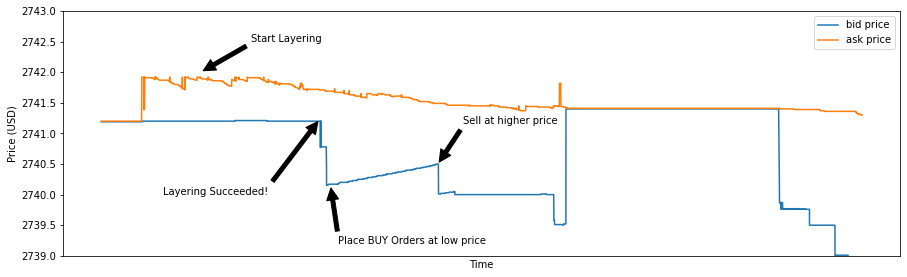

In [54]:
q = data.loc['2017-7-21 9:41:00.000': '2017-7-21 9:42:01.000' ]

ymin, ymax = 2739, 2743

q.bid.plot(label="bid price")
q.ask.plot(label="ask price")

plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend(loc='best', frameon=True)

plt.ylim(ymin, ymax)

plt.annotate('Start Layering', xy=('2017-7-21 9:41:08.000', 2742), xytext=('2017-7-21 9:41:12.000', 2742.5),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Layering Succeeded!', xy=('2017-7-21 9:41:17.600', 2741.25), xytext=('2017-7-21 9:41:05.000', 2740),arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Place BUY Orders at low price', xy=('2017-7-21 9:41:18.400', 2740.15), xytext=('2017-7-21 9:41:19.000', 2739.2),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Sell at higher price', xy=('2017-7-21 9:41:27.000', 2740.5), xytext=('2017-7-21 9:41:29.000', 2741.15),arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

#### "Momentum ignition"是一种市场操纵策略，通过快速购买或卖出大量的资产来推动价格，从而吸引其他市场参与者跟随交易。在这种策略中，交易者通常会使用自动化交易程序来执行快速交易。这些程序可以以毫秒级别的速度执行交易，并在短时间内购买或卖出大量的资产。这种策略通常用于低流动性市场，因为在这些市场中，大量的交易可以对资产价格产生显著的影响。当价格开始上涨或下跌时，其他市场参与者可能会跟随交易，从而进一步推动价格。当交易者感到价格已经达到他们所期望的水平时，他们会快速平仓并退出市场，从而获得利润。

>为了检测动量的点燃，必须关注以下三个主要特征，如下图所示：

>1.稳定的价格和尖锐的成交量
>2.与日内波动率相比，价格变动较大
>3.在较低的成交量下恢复到起始价格

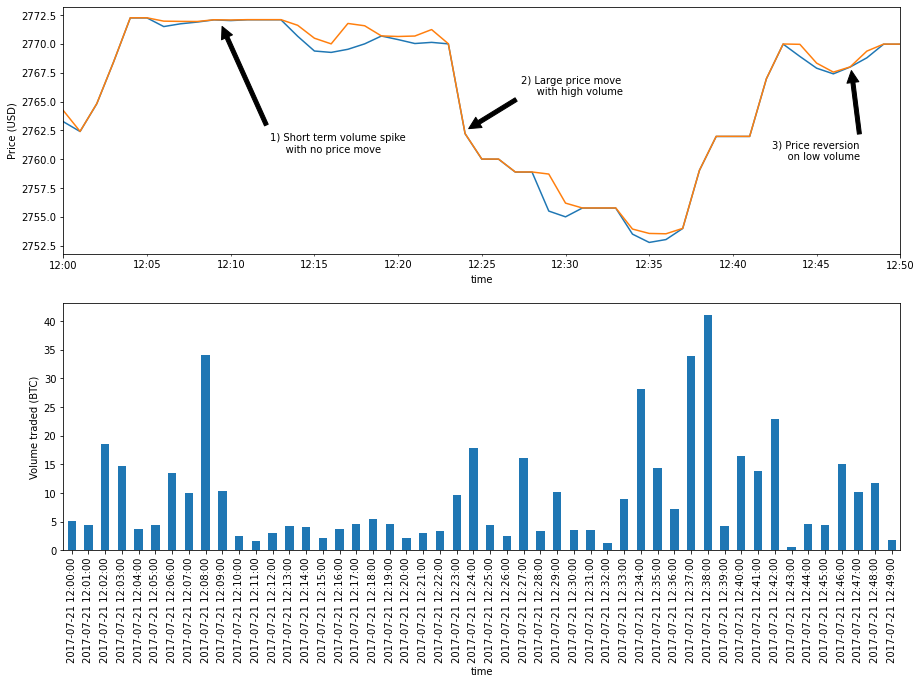

In [60]:
plt.figure(figsize=(15,10))
plt.subplot(211)
t0 = '2017-7-21 12:00:20.000'
t1 = '2017-7-21 12:50:01.000' 

q = data.loc[t0:t1].resample('60S')
bids = q.bid.last()
asks = q.ask.last()
vol = data[data.type=='match'].loc[t0:t1].resample('60S')['size'].sum()

bids.plot()
asks.plot()
plt.ylabel("Price (USD)")
plt.annotate('1) Short term volume spike\n     with no price move', xy=('2017-7-21 12:09:20.000', 2772.0), xytext=('2017-7-21 12:12:20.000', 2760.6),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('2) Large price move\n     with high volume', xy=('2017-7-21 12:24:03.000', 2762.5), xytext=('2017-7-21 12:27:20.000', 2765.6),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('3) Price reversion\n     on low volume', xy=('2017-7-21 12:47:03.000', 2768.0), xytext=('2017-7-21 12:42:20.000', 2760.0),arrowprops=dict(facecolor='black', shrink=0.05))


plt.subplot(212)
vol.plot(kind='bar')
plt.ylabel("Volume traded (BTC)")

plt.show()